Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "KIRILL GROMOV"
COLLABORATORS = ""

---

# Метод наименьших квадратов (линейный случай).

Рассмотрим функцию $y = f(x)$ определенной набором значений $y_0, y_1, \cdots, y_n$ в точках $x_0, x_1, \cdots, x_n$.

In [2]:
import numpy as np

x = np.asarray([-1, -0.7, -0.43, -0.14, 0.14, 0.43, 0.71, 1, 1.29, 1.57, 1.86, 2.14, 2.43, 2.71, 3])
y = np.asarray([-2.25, -0.77, 0.21, 0.44, 0.64, 0.03, -0.22, -0.84, -1.2, -1.03, -0.37, 0.61, 2.67, 5.04, 8.90])

rng = np.random.default_rng(123)
x += 0.1 * rng.uniform(size=len(x))
y += 4 * rng.uniform(size=len(x))

### I. Найдите многочлен наилучшего приближения,

$$
P_m(x) = a_0 + a_1 x + \cdots + a_m x^m
$$

используя линейный метод наименьших квадратов.Для этого:

1. реализуйте алгоритм, создающий  "design matrix" `А`, используя $1, x, \cdots, x^m$ в качестве базисных функций.

2. постройте явно нормальную систему уравнений задачи наименьших квадратов при фиксированных значениях $m$.

3. решите систему уравнений, чтобы найти коэффициенты $P_m(x)$ для $m = 0, 1, 2, \dots$. Для решения задач линейной алгебры можете использовать либо библиотечные функции (`numpy.linalg.solve`), либо Вашу реализацию LU - разложение из 1 недели.

In [3]:
import numpy as np

def design_matrix(x, m):
    """Construct the design matrix with monomials x**k for k=0..m-1"""
    # YOUR CODE HERE
    result = np.zeros((len(x), m))
    for k in range(m):
      for i in range(len(x)):
        result[i, k] = x[i]**k
    return result

In [4]:
assert design_matrix(x, 3).shape == (len(x), 3)
assert design_matrix(x, 11).shape == (len(x), 11)

In [5]:
def lsq_poly(x, y, m):
    """Construct the LSQ polynomial of degree `m-1`.
    
    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The number of coefficients of the LSQ polynomial
        (i.e. the degree of the polynomial is `m-1`)
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
        
    Examples
    --------
    >>> p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
    >>> p(np.array([1.5, 2.5]))
    array([4.5, 5.5])
    
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))
    
    # YOUR CODE HERE
    A = design_matrix(x, m)
    b = A.transpose() @ y
    sol = np.linalg.solve(A.transpose() @ A, b)
    return np.polynomial.Polynomial(sol)
p = lsq_poly([1, 2, 3], [4, 5, 6], m=2)
p

Polynomial([3., 1.], domain=[-1,  1], window=[-1,  1])

In [6]:
import pytest
with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2], m=1)

with pytest.raises(ValueError):
    lsq_poly([1, 2, 3], [1, 2, 3], m=3)
    
# test that lsq_poly returns a callable object
# which support vectorized evaluation
p = lsq_poly(x, y, m=3)
assert len(p(x)) == len(x)

Вычислите число обусловленности матрицы `A` и матрицы левой части системы нормальных уравнений в зависимости $m$, и напечатайте их на экран.
Прокомментируйте полученные результаты.

In [7]:
for m in range(1, 10):
  # YOUR CODE HERE
  A = design_matrix(x, m)
  AtA = A.transpose() @ A
  print(np.linalg.cond(AtA))
  # Системы нормальных уравнений плохо обусловлены. 
  # Число обусловленности матрицы в левой части системы, т.е. матрицы A^T @ A, 
  # равно квадрату числа обусловленности матрицы A: cond(AtA) = cond(A)^2.
  # Это ведёт к огромным погрешностям при вычислениях.

1.0
6.470306190618083
63.586639271496125
1132.7482300049744
22266.425291572934
502913.211111679
13161279.61546711
336583014.0451297
10490798223.351402


In [8]:
# This cell is a test: keep it intact

### BEGIN HIDDEN TESTS

from numpy.testing import assert_allclose

for m in range(1, 10):
    a = design_matrix(x, m)
    assert_allclose(np.linalg.cond(a)**2,
                    np.linalg.cond(a.T @ a), rtol=1e-2)
### END HIDDEN TESTS

### II. Многочлен наилучшего приближения.

Ясно, что бесконтрольно увеличивать степень аппроксимирующего многочлена довольно бессмысленно. Зададимся целью построить "оптимальный" многочлен как можно более низкой степени $m$.

Для нахождения оптимального значения $m$ используйте следующий критерий: возьмем $m = 1, 2, \dots$, и для каждого значения $m$ вычислим

$$
\sigma_m^2 = \frac{1}{n - m} \sum_{k=0}^n \left( P_m(x_k) - y_k \right)^2
$$

и возьмем такое значение $m$, при котором $\sigma_m$ стабилизируется или начинает расти.

In [9]:
def sigma(x, y, m):
    """Compute $\sigma_m$."""
    # YOUR CODE HERE
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.shape[0] != y.shape[0]:
        raise ValueError("Expect paired data.")
    if x.shape[0] <= m:
        raise ValueError("Cannot fit a degree-%s polynomial through %s points" % (m, x.shape[0]))

    n = x.shape[0]
    sum = 0
    P = lsq_poly(x, y, m=m)
    for k in range(n):
      sum += (P(x[k]) - y[k])**2
    res = (1/(n - m) * sum) ** 0.5
    return res

In [10]:
for m in range(1, 15):
    print(m, sigma(x, y, m))

1 3.384875484757168
2 2.9189179439296478
3 2.0013905311655114
4 1.0656644349945168
5 1.0617283168626122
6 1.058704639253703
7 1.0025108400404112
8 1.0489549438870267
9 1.12514510404996
10 0.8775643123460994
11 0.39956237922403465
12 0.41750059283615076
13 0.1404667262799026
14 0.140087108901995


Постройте ваши полиномы $P_m(x)$ вместе с данными. Визуально сравните полиномы различных степеней. Согласуется ли визуальное сравнение с ожидаемым оптимальным значением $m$?

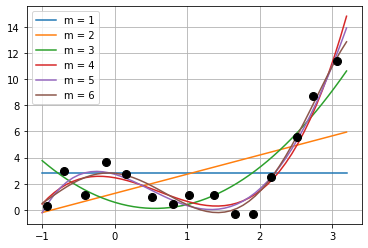

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for m in range(1, 7):
    p = lsq_poly(x, y, m)
    
    xx = np.linspace(-1, 3.2, 51)
    ax.plot(xx, p(xx), '-', label='m = %s' % m)

ax.plot(x, y, 'o', ms=8, color='k')
plt.legend(loc='best')
plt.grid()

### III. МНК с использованием QR-разложения.

Для оптимального значения $m$ из предыдущей части решите задачу МНК, QR-разложение design матрицы. Для решения задач линейной алгебры можете использовать библиотечные функции (обратите внимание на `scipy.linalg.solve_triangular` и `scipy.linalg.qr` и т.д.) или код предыдущих недель.
Сравните результат с ответом, полученным при решении системы уравнений.

In [12]:
def lsq_qr(x, y, m):
    """Solve the LSQ problem via the QR decomp of the design matrix.

    Parameters
    ----------
    x : array_like
        Sample points
    y : array_like
        Measured values
    m : int
        The degree of the LSQ polynomial
        
    Returns
    -------
    p : callable 
        np.polynomial.Polynomial instance, representing the LSQ polynomial
    
    """
    # YOUR CODE HERE
    import scipy.linalg
    A = design_matrix(x, m)
    Q, R = scipy.linalg.qr(A)
    fr_vec = Q.transpose() @ y
    f = fr_vec[:m]
    r = fr_vec[m:]
    sol = scipy.linalg.solve_triangular(R[:m], f)
    return np.polynomial.Polynomial(sol)
lsq_qr(x, y, m=4)

Polynomial([ 2.45699683, -0.96800199, -1.90876006,  1.06766915], domain=[-1,  1], window=[-1,  1])

In [13]:
from numpy.testing import assert_allclose

for m in range(1, 10):
    assert_allclose(lsq_qr(x, y, m=m).coef,
                    lsq_poly(x, y, m=m).coef,
                    atol=1e-14)

In [14]:
# This cell spot-tests several polynomials to make sure that they are worse than your ``best'' polynomial.


### BEGIN HIDDEN TESTS
p = lsq_qr(x, y, m=4)
s = ((p(x) - y)**2).sum() / (y.shape[0] - m)

rndm = np.random.RandomState(123)

for _ in range(10):
    coef = p.coef + 0.1*rndm.uniform(size=p.coef.shape[0])
    pp = np.polynomial.Polynomial(coef)
    spp = ((pp(x) - y)**2).sum() / (y.shape[0] - m)

    assert s < spp

### END HIDDEN TESTS